# <hr style="clear: both" />

# Running Spark in YARN-client mode

This notebook demonstrates how to set up a SparkContext that uses SURFsara's Hadoop cluster: [YARN resourcemanager](http://head05.hathi.surfsara.nl:8088/cluster) (note you will need to be authenticated via kerberos on your machine to visit the resourcemanager link) for executors.

First initialize kerberos via a Jupyter terminal. 
In the terminal execute: <BR>
<i>kinit -k -t data/robertop.keytab robertop@CUA.SURFSARA.NL</i><BR>
Print your credentials:


In [1]:
! klist

Ticket cache: FILE:/tmp/krb5cc_1000
Default principal: robertop@CUA.SURFSARA.NL

Valid starting       Expires              Service principal
05/20/2016 11:47:38  05/21/2016 11:47:38  krbtgt/CUA.SURFSARA.NL@CUA.SURFSARA.NL
	renew until 05/20/2016 11:47:38


In [2]:
! hdfs dfs -ls 
execfile('../spark-scripts/bullet.py')

Found 5 items
drwx------   - robertop hdfs          0 2016-05-20 06:00 .Trash
drwxr-xr-x   - robertop hdfs          0 2016-05-20 19:50 .sparkStaging
drwx------   - robertop hdfs          0 2016-04-06 15:54 .staging
drwxr-xr-x   - robertop hdfs          0 2016-05-19 19:23 mattia
drwxr-xr-x   - robertop hdfs          0 2016-04-13 10:00 recsys2016Competition


Verify that we can browse HDFS:

Next initialize Spark. Note that the code below starts a job on the Hadoop cluster that will remain running while the notebook is active. Please close and halt the notebook when you are done. Starting the SparkContext can take a little longer. You can check the YARN resourcemanager to see the current status/usage of the cluster.

In [3]:
import os
os.environ['PYSPARK_PYTHON'] = '/usr/local/bin/python2.7'

HDFS_PATH = "hdfs://hathi-surfsara"

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sconf = SparkConf(False)

sconf.setAppName("mattia")

# Master is now yarn-client. The YARN and hadoop config is read from the environment
sconf.setMaster("yarn-client")

# You can control many Spark settings via the SparkConf. This determines the amount of executors on the cluster:
sconf.set("spark.executor.instances", "200")
#sconf.set("spark.executor.memory", "20g")

# UFW (firewall) is active on the VM. We explicitly opened these ports and Spark should not bind to random ports:
sconf.set("spark.driver.port", 51800)
sconf.set("spark.fileserver.port", 51801)
sconf.set("spark.broadcast.port", 51802)
sconf.set("spark.replClassServer.port", 51803)
sconf.set("spark.blockManager.port", 51804)
sconf.set("spark.authenticate", True)
sconf.set("spark.yarn.keytab", "/home/jovyan/work/data/robertop.keytab")
sconf.set("spark.yarn.access.namenodes", HDFS_PATH + ":8020")

try:
    sc = SparkContext(conf=sconf)
    sqlCtx = SQLContext(sc) 
    sendNotificationToMattia("Spark Context", "Ready!")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err)) 
    print str(err)

# <hr style="clear: both" />

# Now you can run your code

Pick a clustering algorithm (name of the file that provides a classify(x,y [,threshold]) function)

In [5]:
execfile('../spark-scripts/conventions.py')
execfile('../spark-scripts/splitCluster.py')
#execfile('../spark-scripts/utils.py')
execfile('../spark-scripts/eval.py')
execfile('../spark-scripts/implicitPlaylistAlgoFunctions.py')
execfile('../spark-scripts/implicitPlaylistAlgoMain.py')

CLUSTER_ALGO = 'jaccardBase'
THRESHOLD = 0.9
print str(THRESHOLD)[2:]
execfile('../spark-scripts/' + CLUSTER_ALGO + '.py')


9


# Reading the conf file

In [6]:
import json
import copy

BASE_PATH = HDFS_PATH + '/user/robertop/mattia'

conf = {}

conf['split'] = {}
conf['split']['reclistSize'] = 100
conf['split']['callParams'] = {}
conf['split']['excludeAlreadyListenedTest'] = True
conf['split']['name'] = 'test'
conf['split']['split'] = conf['split']['name']
conf['split']['minEventsPerUser'] = 5
conf['split']['inputData'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/SenzaRipetizioni_1'
#conf['split']['inputData'] = 's3n://contentwise-research-poli/30musicdataset/newFormat/relations/sessions.idomaar'
conf['split']['bucketName'] = BASE_PATH
conf['split']['percUsTr'] = 0.05
conf['split']['ts'] = int(0.75 * (1421745857 - 1390209860) + 1390209860) - 10000
conf['split']['minEventPerSession'] = 5
conf['split']['onlineTrainingLength'] = 5
conf['split']['GTlength'] = 1
conf['split']['minEventPerSessionTraining'] = 10
conf['split']['minEventPerSessionTest'] = 11
conf['split']['mode'] = 'session'
conf['split']['forceSplitCreation'] = False
conf['split']["prop"] = {'reclistSize': conf['split']['reclistSize']}
conf['split']['type'] = list
conf['split']['out'] = HDFS_PATH + '/user/robertop/mattia/clusterBase.split/'
conf['split']['location'] = '30Mdataset/relations/sessions'

conf['evaluation'] = {}
conf['evaluation']['metric'] = {}
conf['evaluation']['metric']['type'] = 'recall'
conf['evaluation']['metric']['prop'] = {}
conf['evaluation']['metric']['prop']['N'] = [1,2,5,10,15,20,25,50,100]
conf['evaluation']['name'] = 'recall@N'

conf['general'] = {}
conf['general']['clientname'] = "clusterBase.split"
conf['general']['bucketName'] = 'head02.hathi.surfsara.nl/user/robertop/mattia'
conf['general']['tracksPath'] = '30Mdataset/entities/tracks.idomaar.gz'

conf['algo'] = {}
conf['algo']['name'] = 'ClusterBase'
conf['algo']['props'] = {}
# ***** EXAMPLE OF CONFIGURATION *****#
conf['algo']['props']["sessionJaccardShrinkage"] = 5
conf['algo']['props']["clusterSimilarityThreshold"] = 0.1
conf['algo']['props']["expDecayFactor"] = 0.7
# ****** END EXAMPLE ****************#




# Load the list of songs ad create clusters


In [7]:
import json
import string

def my_replace_punct(x):
    ret = ""
    for i in x:
        if i == '+':
            ret += ' '
        else:
            ret += i
    return ret

tracksRDD = sc.textFile(BASE_PATH + '/30Mdataset/entities/tracks.idomaar.gz')
tracksRDD = tracksRDD.repartition(200)
tracksRDD = tracksRDD.map(lambda x: x.split('\t')).map(lambda x: (x[1], json.loads(x[3])['name'].split('/') ) )
tracksRDD = tracksRDD.map(lambda x: (x[0], " ".join( (x[1][0], x[1][2]) ) )).distinct()
tracksRDD = tracksRDD.map(lambda x : (x[0], my_replace_punct(x[1])))

ZZ_TOP = 3893303
tracksRDD = tracksRDD.filter(lambda x: int(x[0]) < ZZ_TOP)
tracksRDD = tracksRDD.map(lambda x: (x[0], tokenize_song(x[1]), x[1]))

tracksIdsRDD = tracksRDD.map(lambda x: (int(x[0]), [x[0]]))

try:
    n_tracks = str(tracksRDD.count())
    n_tracksID = str(tracksIdsRDD.count())
    print "Tracks: " + n_tracks
    print "IDs: " + n_tracksID
    parts = str(tracksRDD.getNumPartitions())
    sendNotificationToMattia("Tracks loaded. " + parts + " parts", "Tracks: " + n_tracks + "IDs: " + n_tracksID)
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))    
    print str(err)


Tracks: 3893303
IDs: 3893303


# Remove the 100 longest songs

In [8]:
TOP_N = 100
longSong = tracksRDD.map(lambda x: (x[0], len(x[1]))).takeOrdered(TOP_N, lambda x: -x[1])
longSong = [i[0] for i in longSong]
print longSong

[u'74141', u'750321', u'3152622', u'2827538', u'3152620', u'3152621', u'2827545', u'3152619', u'3341180', u'3152623', u'3152618', u'2827540', u'2827541', u'2827552', u'2827542', u'141134', u'2827551', u'2827550', u'781026', u'2827544', u'2827553', u'1674589', u'3363685', u'2827546', u'2827549', u'2827543', u'2680576', u'3544157', u'2827547', u'2827548', u'3544156', u'2827539', u'2754946', u'928716', u'3152606', u'3375879', u'3152605', u'3152604', u'3152607', u'3152602', u'105580', u'3152603', u'3152601', u'3152608', u'1230495', u'410557', u'742648', u'2171839', u'2652403', u'2520106', u'3068573', u'3396589', u'1994217', u'3095948', u'2036942', u'2706385', u'1994226', u'3755457', u'3395838', u'1675513', u'1994216', u'922515', u'1994220', u'1886095', u'1600901', u'2955525', u'1994227', u'482609', u'1994221', u'1994214', u'1668615', u'1089324', u'2696994', u'2696995', u'828373', u'1089325', u'3206202', u'1994223', u'1807301', u'2702002', u'2696998', u'3341156', u'1994229', u'760742', u'75

In [9]:
REMOVE_LONG_TITLES = True
if REMOVE_LONG_TITLES:
    tracksRDD = tracksRDD.filter(lambda x: x[0] not in longSong)
    print tracksRDD.count()
    
TESTING = False
if TESTING:
    tracksRDD = tracksRDD.take(50000)
    tracksRDD = sc.parallelize(tracksRDD)
    print tracksRDD.take(3)

3893203


# Build RDD with word/bigram mapped to songs


In [10]:
#Map to Bigram -> (id,name)
def extract_bigrams(x):
    result = []
    tokens = x[1]
    l = len(tokens)
    for i in range(l-1):
        bigram = tokens[i] + ' ' + tokens[i+1]
        result.append((bigram, (x[0], x[2])))
    return result

#Map to word -> (id,name)
def extract_words(x):
    result = []
    tokens = x[1]
    for t in tokens:
        result.append( (t, (x[0], x[2])) )
    return result
 
''' CHOOSE ONE OF THE ABOVE FUNCTIONS FOR THE FLAT MAP '''
#Build an RDD with ('word' or 'bigram' -> (id, name))
wordsRDD = tracksRDD.flatMap( extract_bigrams )
print wordsRDD.take(3)

#Group by 'word' and keep only the ones with more then 1 song
wordsRDD = wordsRDD.groupByKey().filter(lambda x: len(x[1]) > 1)

#Eliminate words in top 0.1% of words
total_words = wordsRDD.count()
print "\nTotal words with more than one song: " + str(total_words)
    
nwords = 100 #int(total_words*0.001)
top_words_count = wordsRDD.map(lambda x: (x[0], len(x[1])))
    
total_number_of_songs = top_words_count.reduce(lambda x,y: (0, x[1] + y[1]))[1]
print "Total number of songs present: " + str(total_number_of_songs)
    
top_words_count = top_words_count.takeOrdered(nwords, lambda x: -x[1])
    
print str(top_words_count) + "\n"

[(u'talk talk', (u'2740924', u'Talk Talk Such A Shame (Dub Mix)')), (u'talk such', (u'2740924', u'Talk Talk Such A Shame (Dub Mix)')), (u'such a', (u'2740924', u'Talk Talk Such A Shame (Dub Mix)'))]

Total words with more than one song: 1443568
Total number of songs present: 13210053
[(u'of the', 49035), (u'in the', 39210), (u'original mix', 37890), (u'and the', 22308), (u'on the', 16901), (u'radio edit', 15441), (u'to the', 14769), (u'album version', 13491), (u'in a', 11743), (u'live at', 11153), (u'digital remaster', 10886), (u'for the', 9801), (u'at the', 9649), (u'the world', 9117), (u'bonus track', 9028), (u'from the', 8970), (u'in d', 8078), (u'of a', 7602), (u'in my', 7346), (u'the sun', 7240), (u'in c', 6712), (u'sebastian bach', 6682), (u'johann sebastian', 6610), (u'i am', 6552), (u'the night', 6178), (u'in love', 6174), (u'of love', 6149), (u'live in', 6090), (u'to be', 6081), (u'de la', 6027), (u'no 1', 6003), (u'out of', 5957), (u'in g', 5935), (u'i love', 5669), (u'single

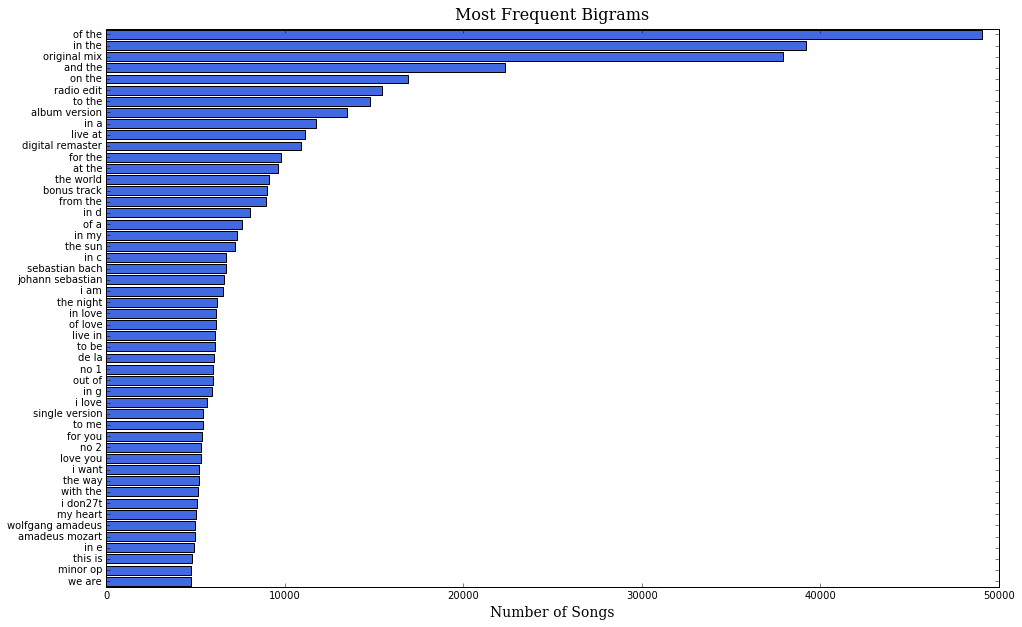

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

font_title = {'family': 'serif',
                   'weight': 'normal',
                   'verticalalignment': 'bottom',
                   'size': 16}  
font_labels = {'family': 'serif',
                   'weight': 'normal',
                   'size': 14}   

N = 50
val = list(reversed([i[1] for i in top_words_count[:N]]))
labels = list(reversed([i[0] for i in top_words_count[:N]]))
pos = [i + .5 for i in range(len(val))]

plt.figure(1, figsize = (16,10))
plt.barh(pos, val, align = 'center', color = 'royalblue')
plt.yticks(pos, labels)
plt.xlabel('Number of Songs', fontdict = font_labels)
plt.title('Most Frequent Bigrams', fontdict = font_title)

plt.show()


In [12]:
top_words_count

[(u'of the', 49035),
 (u'in the', 39210),
 (u'original mix', 37890),
 (u'and the', 22308),
 (u'on the', 16901),
 (u'radio edit', 15441),
 (u'to the', 14769),
 (u'album version', 13491),
 (u'in a', 11743),
 (u'live at', 11153),
 (u'digital remaster', 10886),
 (u'for the', 9801),
 (u'at the', 9649),
 (u'the world', 9117),
 (u'bonus track', 9028),
 (u'from the', 8970),
 (u'in d', 8078),
 (u'of a', 7602),
 (u'in my', 7346),
 (u'the sun', 7240),
 (u'in c', 6712),
 (u'sebastian bach', 6682),
 (u'johann sebastian', 6610),
 (u'i am', 6552),
 (u'the night', 6178),
 (u'in love', 6174),
 (u'of love', 6149),
 (u'live in', 6090),
 (u'to be', 6081),
 (u'de la', 6027),
 (u'no 1', 6003),
 (u'out of', 5957),
 (u'in g', 5935),
 (u'i love', 5669),
 (u'single version', 5432),
 (u'to me', 5419),
 (u'for you', 5357),
 (u'no 2', 5314),
 (u'love you', 5302),
 (u'i want', 5179),
 (u'the way', 5170),
 (u'with the', 5141),
 (u'i don27t', 5063),
 (u'my heart', 5030),
 (u'wolfgang amadeus', 4999),
 (u'amadeus moza

In [ ]:
REMOVE = 16
song_removed = 0
top_words = []
for i in top_words_count:
    song_removed += i[1]
    top_words.append(i[0])
    
print "\nSong removed: " + str(song_removed)

print top_words[:REMOVE]
wordsRDD = wordsRDD.filter(lambda x: x[0] not in top_words[:REMOVE])
    


Song removed: 684571
[u'of the', u'in the', u'original mix', u'and the', u'on the', u'radio edit', u'to the', u'album version', u'in a', u'live at', u'digital remaster', u'for the', u'at the', u'the world', u'bonus track', u'from the']


# Classify songs inside the same list (word/bigram)

In [ ]:
#Compute a cartesian product for each list of songs with a common word
def filtered_cartesian(x):
    equal_couples = set()
    x_1 = list(x[1])
    for i in range(len(x_1)):
        a = x_1[i]
        id_a = x_1[i][0]
        name_a = x_1[i][1]
        
        for j in range(i):
            b = x_1[j]
            id_b = x_1[j][0]
            name_b = x_1[j][1]
            if id_a != id_b:
                if classify(name_a, name_b, THRESHOLD):
                    equal_couples.add( (int(id_a), (id_a, id_b)) )
                    equal_couples.add( (int(id_b), (id_a, id_b)) )
                    
    return list(equal_couples)

coupleRDD = wordsRDD.flatMap(filtered_cartesian)
try:
    n_couples = coupleRDD.count()
    print n_couples
    sendNotificationToMattia("Words!", str(n_couples) + " Couples found.")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))
    print str(err)

# Group by Song

In [ ]:
#Group by key (song). Each song has now one cluster
def merge_couples(x, y):
    return list(set(x) | set(y))

try:
    songClusterRDD = coupleRDD.reduceByKey(merge_couples)
    print songClusterRDD.count()
    print songClusterRDD.take(10)
    sendNotificationToMattia("Song to Cluster!", str(songClusterRDD.take(10)))
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))
    print str(err)

# Unify with all the Songs (not clustered)

In [ ]:
#In this way we obtain a complete RDD with song -> group of songs
def reduce_to_biggest(x, y):
    bigger = x if len(x) > len(y) else y
    result = sorted(bigger)
    return result
 
unionJoinRDD = tracksIdsRDD.leftOuterJoin(songClusterRDD)
unionRDD = unionJoinRDD.map(lambda x: (x[0], x[1][0]) if x[1][1] == None else (x[0], x[1][1]))

try:
    tot_n = unionRDD.count()
    print tot_n
    print unionRDD.take(10)
    sendNotificationToMattia(str(tot_n) + " Tracks unified with all tracks ids", "Inverting and unifying clusters...")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))
    print str(err)

# Build indexing for clusters (new IDs)

In [ ]:
#Flip the mapping as cluster->song
clusterSongsRDD = unionRDD.map(lambda x: (' '.join(x[1]), x[0])).groupByKey().mapValues(list)
clusterSongsRDD = clusterSongsRDD.zipWithIndex().map(lambda x: (x[1], x[0][1]))

try:
    tot_n = clusterSongsRDD.count()
    print tot_n
    sendNotificationToMattia(str(tot_n) + " Unique clusters found!", "Writing...")
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))
    print str(err)

# Write results 

In [ ]:
#Save clustering
THRESHOLD_STR = str(THRESHOLD)[2:]
try:
    clusterSongsRDD.saveAsPickleFile(BASE_PATH + '/clusters/' + CLUSTER_ALGO + THRESHOLD_STR)
    sendNotificationToMattia("File Written!", BASE_PATH + '/clusters/' + CLUSTER_ALGO + THRESHOLD_STR)
except Exception, err:
    sendNotificationToMattia("Fuck you!", str(err))
    print str(err)

In [20]:
sc